# Constant Mask

GeoTIFF saved to ../constant_masks/soil_type.tif (compatible with ArcMap)


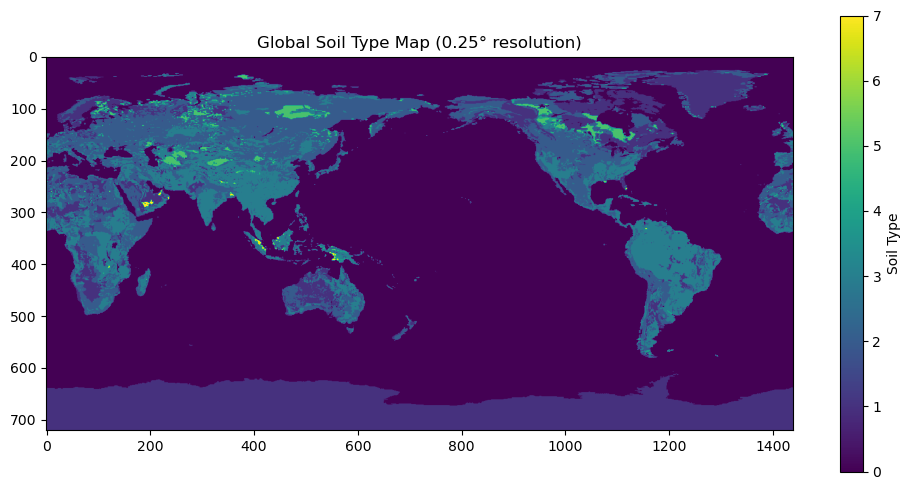

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from osgeo import gdal, osr

# Load soil type data
soiltype = np.load('../constant_masks/soil_type.npy')

# Display the soil type data
plt.figure(figsize=(10, 5))
plt.imshow(soiltype, cmap='viridis')
plt.colorbar(label='Soil Type')
plt.title('Global Soil Type Map (0.25° resolution)')
plt.tight_layout()

# Export as GeoTIFF using GDAL (more compatible with ArcMap)
# Create output dataset
driver = gdal.GetDriverByName('GTiff')
out_path = '../constant_masks/soil_type.tif'
dataset = driver.Create(out_path, 1440, 721, 1, gdal.GDT_Float32)

# Set geotransform parameters (origin at top-left corner: 90N, 0E)
# Parameters: [top_left_x, pixel_width, 0, top_left_y, 0, pixel_height]
dataset.SetGeoTransform([0, 0.25, 0, 90, 0, -0.25])  # Note negative pixel height

# Set projection
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)  # WGS84
dataset.SetProjection(srs.ExportToWkt())

# Write data
dataset.GetRasterBand(1).WriteArray(soiltype)

# Close dataset to flush to disk
dataset = None
print(f"GeoTIFF saved to {out_path} (compatible with ArcMap)")


# upper air to weekly

In [1]:
import numpy as np
temp = np.load('F:/ERA5_weekly_npy/crr.npy')
temp.shape



(1248, 721, 1440)

In [2]:
import xarray as xr
ds = xr.open_mfdataset('I:/ERA5/upper air/vertical_velocity/ERA5_20000101.nc')
ds

<xarray.Dataset>
Dimensions:         (valid_time: 1, pressure_level: 4, latitude: 721,
                     longitude: 1440)
Coordinates:
    number          int64 ...
  * pressure_level  (pressure_level) float64 850.0 700.0 500.0 300.0
  * latitude        (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude       (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * valid_time      (valid_time) datetime64[ns] 2000-01-01
Data variables:
    w               (valid_time, pressure_level, latitude, longitude) float32 dask.array<chunksize=(1, 4, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-18T13:56 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob
from tqdm import tqdm
import datetime

# 数据存放路径
data_dir = 'I:/ERA5/upper air/vertical_velocity/'

# 获取所有nc文件路径
nc_files = sorted(glob.glob(os.path.join(data_dir, 'ERA5_*.nc')))

# 初始化结果数组 (1248周 x 4气压层 x 721纬度 x 1440经度)
result = np.zeros((1248, 4, 721, 1440), dtype=np.float32)

# 创建日期到周索引的映射
start_date = datetime.datetime(2000, 1, 1)
all_dates = []
week_indices = []

# 生成所有可能的日期和对应的周索引
for year in range(2000, 2024):  # 2000年到2023年
    for month in range(1, 13):  # 1月到12月
        days_in_month = pd.Timestamp(year=year, month=month, day=1).days_in_month
        for day in range(1, days_in_month + 1):
            date = datetime.datetime(year, month, day)
            date_str = date.strftime('%Y%m%d')
            
            # 计算从起始日期开始的周数
            days_since_start = (date - start_date).days
            week_index = days_since_start // 7
            
            if week_index < 1248:  # 确保周索引在有效范围内
                all_dates.append(date_str)
                week_indices.append(week_index)

# 创建日期到周索引的字典
date_to_week = {date: week for date, week in zip(all_dates, week_indices)}

# 创建周计数器，用于计算每周有多少天的数据
week_counts = np.zeros(1248, dtype=int)

# 遍历处理每个nc文件
for nc_file in tqdm(nc_files, desc="处理文件"):
    try:
        # 从文件名提取日期
        date_str = os.path.basename(nc_file).replace('ERA5_', '').replace('.nc', '')
        
        # 检查日期是否在我们的映射中
        if date_str in date_to_week:
            week_idx = date_to_week[date_str]
            
            # 读取nc文件
            ds = xr.open_dataset(nc_file)
            
            # 提取云覆盖率数据 - 修正这里，适应实际数据维度
            cc_data = ds['w'].values
            
            # 检查维度
            if len(cc_data.shape) == 4 and cc_data.shape[0] == 1:  # 如果形状是 (1, 4, 721, 1440)
                cc_data = cc_data[0]  # 变为 (4, 721, 1440)
            
            # 确保维度是 (4, 721, 1440)
            if cc_data.shape == (4, 721, 1440):
                # 累加到对应的周
                result[week_idx] += cc_data
                week_counts[week_idx] += 1
            else:
                print(f"警告: 文件 {nc_file} 的数据形状异常: {cc_data.shape}")
            
            # 关闭数据集
            ds.close()
        
    except Exception as e:
        print(f"处理文件 {nc_file} 时出错: {e}")

# 计算周平均值（避免除以零）
for i in range(1248):
    if week_counts[i] > 0:
        result[i] /= week_counts[i]

# 保存结果为npy文件
output_file = 'F:/ERA5_weekly_upper/vertical_velocity.npy'
np.save(output_file, result)

print(f"数据已保存至 {output_file}")
print(f"结果数组形状: {result.shape}")

# 统计信息
valid_weeks = np.sum(week_counts > 0)
print(f"有效周数: {valid_weeks}/{1248}")
print(f"平均每周数据天数: {np.mean(week_counts[week_counts > 0]):.2f}")

处理文件:   2%|▏         | 136/8766 [00:14<16:14,  8.86it/s]

In [24]:
data = np.load('F:/ERA5_weekly_upper/vertical_velocity.npy')
print(data.dtype)  # 查看数据类型是float32还是float64
data.shape


float32


(1248, 4, 721, 1440)

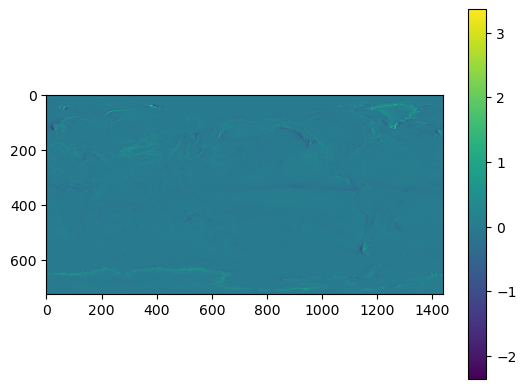

In [25]:
import matplotlib.pyplot as plt
plt.imshow(data[0, 0, :, :])
plt.colorbar()
plt.show()


In [1]:
import torch
data = torch.load('E:/S2S/input_surface_norm_test.pt')
data.shape

torch.Size([16, 100, 721, 1440])

In [3]:
import torch
data = torch.load('E:/S2S/input_upper_air_norm_test.pt')
data.shape

torch.Size([7, 4, 100, 721, 1440])

In [2]:
import numpy as np
data = np.load('F:/ERA5_weekly_upper/fraction_of_cloud_cover.npy')
data.shape

(1248, 4, 721, 1440)

In [1]:
import torch
input_surface = torch.load('../../data/input_surface_norm_test.pt')
input_surface.shape

torch.Size([16, 100, 721, 1440])

In [2]:
import torch
input_surface = torch.load('../../data/input_upper_air_norm_test.pt')
input_surface.shape

torch.Size([7, 4, 100, 721, 1440])

In [1]:
import xarray as xr
xr.open_dataset(r'J:\ERA5\upper air\fraction_of_cloud_cover\ERA5_20000101.nc')

<xarray.Dataset>
Dimensions:         (valid_time: 1, pressure_level: 4, latitude: 721,
                     longitude: 1440)
Coordinates:
    number          int64 ...
  * pressure_level  (pressure_level) float64 850.0 700.0 500.0 300.0
  * latitude        (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude       (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * valid_time      (valid_time) datetime64[ns] 2000-01-01
Data variables:
    cc              (valid_time, pressure_level, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-19T08:05 GRIB to CDM+CF via cfgrib-0.9.1...